In [1]:
# Set project directory
import os
import sys


def project_dir():
    notebook_path = %pwd
    repo_name = "nsl_kdd"
    repo_folder = notebook_path.split(repo_name)[0]
    return os.path.join(repo_folder, repo_name)


pwd = os.getenv("PWD", project_dir())
os.environ["PWD"] = pwd
sys.path.append(pwd)

In [2]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow.keras import layers as k_layers
from tensorflow.keras import optimizers as k_optimizers
from tensorflow.keras import callbacks as k_callbacks

from data_utils import load_train_test_data

# Load data

In [3]:
(X_train, X_test, Y_train, Y_test), attack_labels = load_train_test_data(pwd=pwd)

In [4]:
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((125973, 122), (125973, 5), (22544, 122), (22544, 5))

In [5]:
attack_labels

array(['DoS', 'Probe', 'R2L', 'U2R', 'normal'], dtype='<U6')

# Utils

In [6]:
def fit_model(create_model, X_train, Y_train, X_test, Y_test, batch_size=512, n_epochs=100, lr_start=0.001, lr_patience=None):
    model = create_model(lr_start)
    
    callbacks = []
    if lr_patience is not None:
        callbacks.append(k_callbacks.ReduceLROnPlateau(factor=0.5, patience=lr_patience))
        
    history = model.fit(X_train, Y_train, batch_size=batch_size, epochs=n_epochs, validation_data=(X_test, Y_test), callbacks=callbacks).history
    
    return history, model

def plot_history(history, title, ymax=100):
    plt.figure(figsize=(20, 7))
    
    X = np.arange(1, len(history['loss']) + 1)
    
    for i, metric in enumerate(['loss', 'acc']):
        plt.subplot(1, 2, i + 1)
        plt.plot(X, history[metric], label='train')
        plt.plot(X, history[f'val_{metric}'], label='test')
        if metric == 'acc':
            plt.ylim(0, 1)
        elif ymax is not None:
            plt.ylim(0, ymax)
        plt.title(f"{metric} ({history[f'val_{metric}'][-1]:0.4f})")
        plt.grid()
        plt.legend()
        
    plt.suptitle(title)
    plt.show()

# Model v1

In [7]:
def create_model_v1(lr=0.001):
    model = tf.keras.Sequential([
        k_layers.Input(122),
        k_layers.Dense(5, activation='softmax')
    ])
    
    model.compile(
        k_optimizers.Adam(learning_rate=lr), loss='categorical_crossentropy', metrics=['acc']
    )
    
    return model

# create_model_v1().summary()

In [8]:
history_v1, model_v1 = fit_model(create_model_v1, X_train, Y_train, X_test, Y_test, n_epochs=30, lr_start=0.001, lr_patience=10)

Epoch 1/30
247/247 [==============================] - 1s 3ms/step - loss: 0.7506 - acc: 0.8297 - val_loss: 0.8733 - val_acc: 0.7445 - lr: 0.0010
Epoch 2/30
247/247 [==============================] - 1s 3ms/step - loss: 0.2232 - acc: 0.9616 - val_loss: 0.8640 - val_acc: 0.7294 - lr: 0.0010
Epoch 3/30
247/247 [==============================] - 1s 3ms/step - loss: 0.1569 - acc: 0.9668 - val_loss: 0.8798 - val_acc: 0.7355 - lr: 0.0010
Epoch 4/30
247/247 [==============================] - 1s 3ms/step - loss: 0.1308 - acc: 0.9683 - val_loss: 0.8989 - val_acc: 0.7496 - lr: 0.0010
Epoch 5/30
247/247 [==============================] - 1s 3ms/step - loss: 0.1160 - acc: 0.9694 - val_loss: 0.9203 - val_acc: 0.7603 - lr: 0.0010
Epoch 6/30
247/247 [==============================] - 1s 3ms/step - loss: 0.1058 - acc: 0.9714 - val_loss: 0.9425 - val_acc: 0.7657 - lr: 0.0010
Epoch 7/30
247/247 [==============================] - 1s 3ms/step - loss: 0.0981 - acc: 0.9716 - val_loss: 0.9685 - val_acc: 0.765

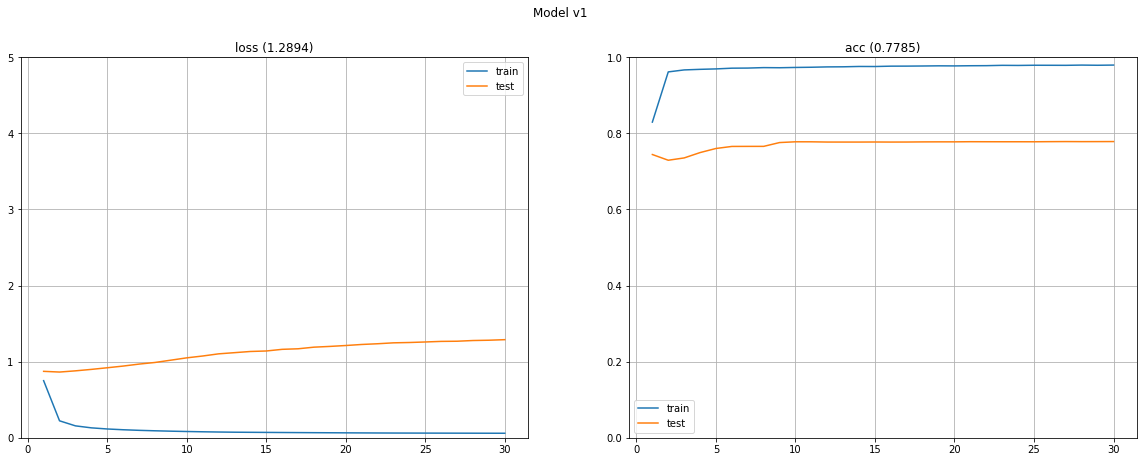

In [9]:
plot_history(history_v1, 'Model v1', ymax=5)

# Model v2

In [10]:
def create_model_v2(lr=0.001):
    model = tf.keras.Sequential([
        k_layers.Input(122),
        
        k_layers.Dense(20),
        k_layers.BatchNormalization(),
        k_layers.ReLU(),
        k_layers.Dropout(0.1),
        
        k_layers.Dense(10),
        k_layers.BatchNormalization(),
        k_layers.ReLU(),
        k_layers.Dropout(0.1),
        
        k_layers.Dense(5, activation='softmax')
    ])
    
    model.compile(
        k_optimizers.Adam(learning_rate=lr), loss='categorical_crossentropy', metrics=['acc']
    )
    
    return model

# create_model_v2().summary()

In [11]:
history_v2, model_v2 = fit_model(create_model_v2, X_train, Y_train, X_test, Y_test, n_epochs=30, lr_start=0.001, lr_patience=10)

Epoch 1/30
247/247 [==============================] - 2s 7ms/step - loss: 0.6610 - acc: 0.8360 - val_loss: 0.8342 - val_acc: 0.7137 - lr: 0.0010
Epoch 2/30
247/247 [==============================] - 2s 6ms/step - loss: 0.2016 - acc: 0.9632 - val_loss: 0.9115 - val_acc: 0.7235 - lr: 0.0010
Epoch 3/30
247/247 [==============================] - 1s 6ms/step - loss: 0.1269 - acc: 0.9707 - val_loss: 0.9843 - val_acc: 0.7614 - lr: 0.0010
Epoch 4/30
247/247 [==============================] - 2s 6ms/step - loss: 0.0923 - acc: 0.9760 - val_loss: 1.0597 - val_acc: 0.7598 - lr: 0.0010
Epoch 5/30
247/247 [==============================] - 1s 6ms/step - loss: 0.0740 - acc: 0.9795 - val_loss: 1.1367 - val_acc: 0.7618 - lr: 0.0010
Epoch 6/30
247/247 [==============================] - 2s 6ms/step - loss: 0.0649 - acc: 0.9813 - val_loss: 1.1627 - val_acc: 0.7597 - lr: 0.0010
Epoch 7/30
247/247 [==============================] - 1s 6ms/step - loss: 0.0572 - acc: 0.9825 - val_loss: 1.2094 - val_acc: 0.764

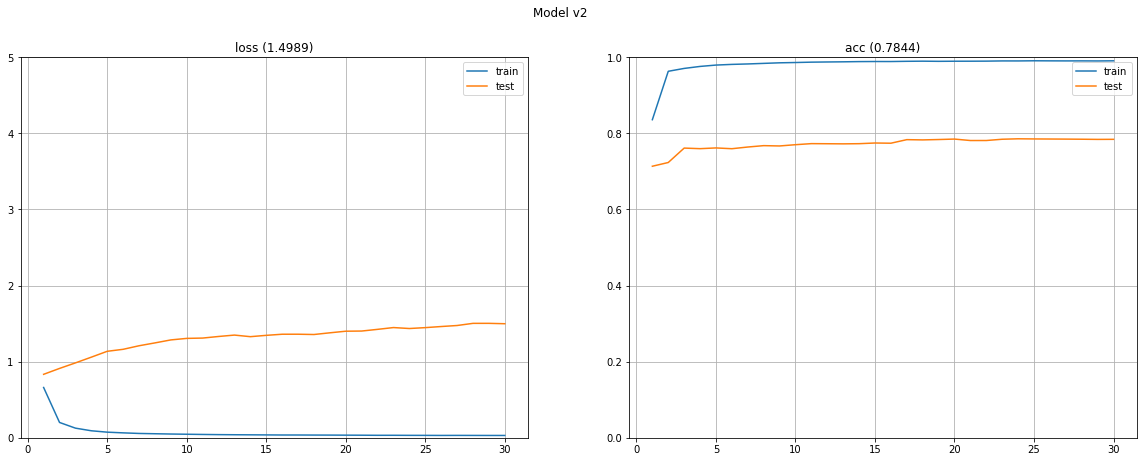

In [12]:
plot_history(history_v2, 'Model v2', ymax=5)

# Model v3

In [13]:
def create_model_v3(lr=0.001):
    model = tf.keras.Sequential([
        k_layers.Input(122),
        
        k_layers.Dense(40),
        k_layers.BatchNormalization(),
        k_layers.ReLU(),
        k_layers.Dropout(0.1),
        
        k_layers.Dense(40),
        k_layers.BatchNormalization(),
        k_layers.ReLU(),
        k_layers.Dropout(0.1),
        
        k_layers.Dense(20),
        k_layers.BatchNormalization(),
        k_layers.ReLU(),
        k_layers.Dropout(0.1),
        
        k_layers.Dense(10),
        k_layers.BatchNormalization(),
        k_layers.ReLU(),
        k_layers.Dropout(0.1),
        
        k_layers.Dense(5, activation='softmax')
    ])
    
    model.compile(
        k_optimizers.Adam(learning_rate=lr), loss='categorical_crossentropy', metrics=['acc']
    )
    
    return model

# create_model_v3().summary()

In [14]:
history_v3, model_v3 = fit_model(create_model_v3, X_train, Y_train, X_test, Y_test, n_epochs=30, lr_start=0.001, lr_patience=10)

Epoch 1/30
247/247 [==============================] - 3s 10ms/step - loss: 0.6496 - acc: 0.8458 - val_loss: 0.8953 - val_acc: 0.7280 - lr: 0.0010
Epoch 2/30
247/247 [==============================] - 2s 9ms/step - loss: 0.1604 - acc: 0.9707 - val_loss: 1.0130 - val_acc: 0.7457 - lr: 0.0010
Epoch 3/30
247/247 [==============================] - 2s 10ms/step - loss: 0.0953 - acc: 0.9779 - val_loss: 1.1150 - val_acc: 0.7571 - lr: 0.0010
Epoch 4/30
247/247 [==============================] - 2s 9ms/step - loss: 0.0694 - acc: 0.9823 - val_loss: 1.1997 - val_acc: 0.7650 - lr: 0.0010
Epoch 5/30
247/247 [==============================] - 2s 10ms/step - loss: 0.0579 - acc: 0.9835 - val_loss: 1.2377 - val_acc: 0.7706 - lr: 0.0010
Epoch 6/30
247/247 [==============================] - 2s 10ms/step - loss: 0.0512 - acc: 0.9847 - val_loss: 1.3167 - val_acc: 0.7713 - lr: 0.0010
Epoch 7/30
247/247 [==============================] - 2s 9ms/step - loss: 0.0463 - acc: 0.9860 - val_loss: 1.3383 - val_acc: 0

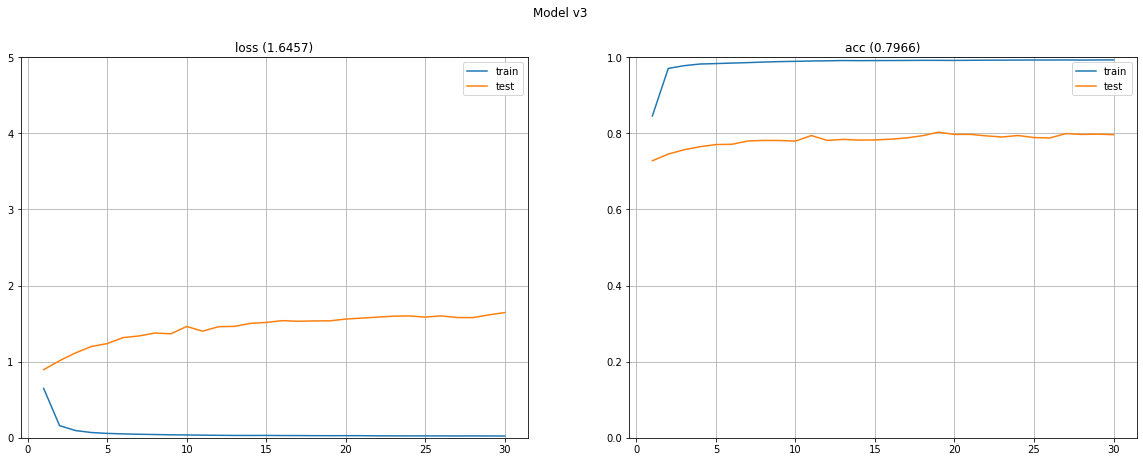

In [15]:
plot_history(history_v3, 'Model v3', ymax=5)